In [1]:
import pandas as pd

df = pd.read_csv("diabetes.csv")

Для начала удалим "пропуски" из данных - строки с нулевыми значениями признаков, 
не подразумевающих этого.

In [2]:
indexes = df[(df.Glucose == 0) | (df.SkinThickness == 0) | 
             (df.BloodPressure == 0) | (df.BMI == 0.0)].index
df.drop(indexes, inplace=True)

In [3]:
N = len(df)
print(N)
df.info()

532
<class 'pandas.core.frame.DataFrame'>
Int64Index: 532 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 532 non-null int64
Glucose                     532 non-null int64
BloodPressure               532 non-null int64
SkinThickness               532 non-null int64
Insulin                     532 non-null int64
BMI                         532 non-null float64
DiabetesPedigreeFunction    532 non-null float64
Age                         532 non-null int64
Outcome                     532 non-null int64
dtypes: float64(2), int64(7)
memory usage: 41.6 KB


In [4]:
df.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
95,6,144,72,27,228,33.9,0.255,40,0
63,2,141,58,34,128,25.4,0.699,24,0
328,2,102,86,36,120,45.5,0.127,23,1
665,1,112,80,45,132,34.8,0.217,24,0
393,4,116,72,12,87,22.1,0.463,37,0


Часть 2: попробуем кластеризовать данные с помощью алгоритма k-means.

In [5]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

DPI = 80
SIZE_X, SIZE_Y = 15, 5
first_k, second_k = 5, 9

В качестве количественных признаков признаков для данного задания выберем

Glucose, BloodPressure, SkinThickness, Insulin и BMI:

In [6]:
need_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
other_features = ['Pregnancies', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
iterations_number = 100

centered_df = pd.DataFrame()
for feature in need_features:
    mean_f, max_f, min_f = df[feature].mean(), df[feature].max(), df[feature].min()
    centered_df[feature] = (df[feature] - mean_f) / (max_f - min_f)

In [7]:
min_distance = 10**10
true_clasters = None
for i in range(iterations_number):
    kmeans = KMeans(n_clusters=first_k, init='random', 
                    random_state=np.random.randint(1000)).fit(centered_df)
    cluster_number = np.array(kmeans.labels_, dtype=int)
    centered_df['cluster'] = cluster_number

    new_centers = centered_df.groupby('cluster').mean().to_numpy()
    centered_df['dist'] = centered_df.apply(lambda x: 
                        sum((x.to_numpy()[:-1] - new_centers[int(x.cluster)])**2), axis=1)

    distance = sum(centered_df.groupby('cluster').sum().dist)
    if distance < min_distance:
        true_clusters = cluster_number 
        min_distance = distance
    centered_df.drop(columns=['dist', 'cluster'], inplace=True, axis=1)

Минимальное расстояние по критерию K-Means для 5 кластеров: 28.6271


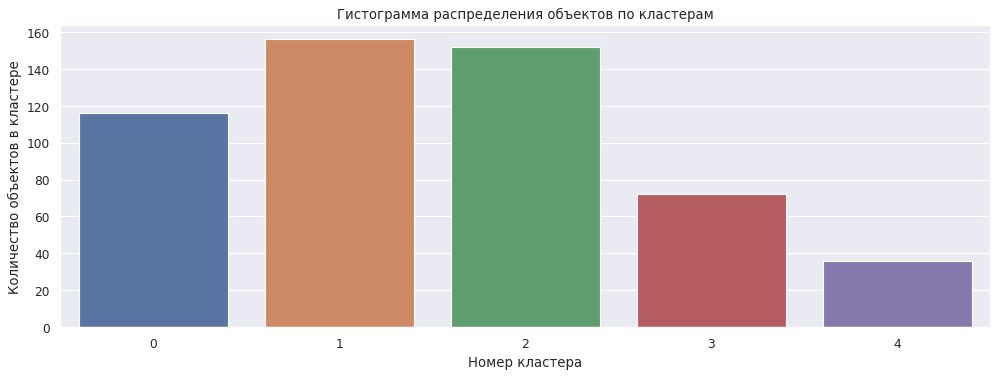

In [8]:
print("Минимальное расстояние по критерию K-Means для 5 кластеров: %.4f" % min_distance)

fig = plt.figure(dpi=DPI, figsize = (SIZE_X, SIZE_Y))
plt.title("Гистограмма распределения объектов по кластерам")
plt.grid(True)
sns.countplot(true_clusters)
plt.ylabel("Количество объектов в кластере")
plt.xlabel("Номер кластера")
fig.savefig("five_clusters.jpg")
plt.show()

По гистограмме видно, что два кластера из пяти получились совсем малочисленными, 

поэтому скорее всего такое разделение не релевантно. 

In [9]:
# интерпретация данных кластеров:

cur_df = df.copy()[need_features]
great_means = cur_df.mean().to_numpy()
cur_df['cluster'] = true_clusters

cluster_diff = 100*(cur_df.groupby('cluster').mean() - great_means) / great_means
cur_df.drop('cluster', inplace=True, axis=1)
cluster_diff

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
cluster,,,,,
0,10.894352,4.392538,-14.095397,-2.321755,-9.573806
1,-13.265890,2.547049,25.009786,-21.960017,14.559403
2,-21.322296,-11.159013,-28.850242,-50.109524,-18.146774
3,40.288822,11.782171,23.743067,12.957938,18.415795
4,31.831328,-1.639459,11.368760,288.298951,7.546305


В нулевом и первом кластерах нет примечательных признаков. Во втором кластере на 50% снижено значение инсулина по сравнению со средним значением, тогда как в четвертый кластер характеризуется увеличением уровня инсулина на 288%! В третьем кластере заметно увеливение уровня глюкозы.
Можно заметить, что кровяное давление и ИМТ ни в одном из кластеров не является сколько-то показательным.

In [10]:
min_distance = 10**10
true_clasters = None
for i in range(iterations_number):
    kmeans = KMeans(n_clusters=second_k, init='random', 
                    random_state=np.random.randint(1000)).fit(centered_df)
    cluster_number = np.array(kmeans.labels_, dtype=int)
    centered_df['cluster'] = cluster_number

    new_centers = centered_df.groupby('cluster').mean().to_numpy()
    centered_df['dist'] = centered_df.apply(lambda x: 
                        sum((x.to_numpy()[:-1] - new_centers[int(x.cluster)])**2), axis=1)

    distance = sum(centered_df.groupby('cluster').sum().dist)
    if distance < min_distance:
        true_clusters = cluster_number 
        min_distance = distance
    centered_df.drop(columns=['dist', 'cluster'], inplace=True, axis=1)

Минимальное расстояние по критерию K-Means для 9 кластеров: 21.7409


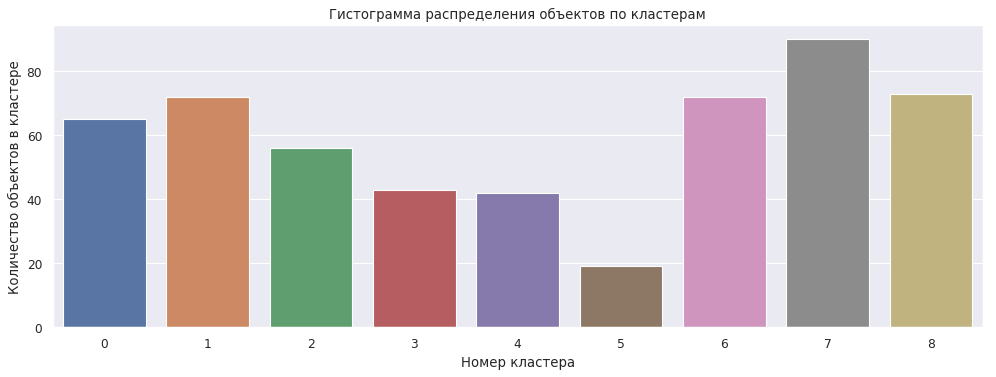

In [11]:
print("Минимальное расстояние по критерию K-Means для 9 кластеров: %.4f" % min_distance)

fig = plt.figure(dpi=DPI, figsize = (SIZE_X, SIZE_Y))
plt.title("Гистограмма распределения объектов по кластерам")
plt.grid(True)
sns.countplot(true_clusters)
plt.ylabel("Количество объектов в кластере")
plt.xlabel("Номер кластера")
fig.savefig("nine_clusters.jpg")
plt.show()

In [12]:
# интерпретация данных кластеров:

cur_df = df.copy()[need_features]
great_means = cur_df.mean().to_numpy()
cur_df['cluster'] = true_clusters

cluster_diff = 100*(cur_df.groupby('cluster').mean() - great_means) / great_means
cur_df.drop('cluster', inplace=True, axis=1)
cluster_diff

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
cluster,,,,,
0,10.360363,13.600508,0.324142,-24.019304,-3.235222
1,-19.843156,-20.849288,-34.416175,-34.317230,-21.916180
2,18.786886,-6.750611,-14.821256,81.912250,-10.899495
3,50.145268,6.220278,11.966446,9.009680,7.991368
4,19.116399,18.372283,43.188406,56.350737,34.878688
5,37.938746,0.985779,21.739130,370.114755,11.887345
6,-8.482343,-13.274128,16.461263,-5.872411,11.030116
7,-19.533315,1.623687,-26.972553,-66.518456,-16.476368
8,-22.027758,10.231751,24.488915,-53.860871,14.423802


Интересны значения, по модулю превосходящие 30: Glucose (3-ий кластер), SkinThickness(1-ый и 4-ый кластеры), Insulin(все, кроме 0-го, 3-го и 6-го кластеров), BMI (4-ый кластер)

При различных случайных наборах центров получаются раличные кластеры, однако всегда хотя бы один кластер практически не содержит элементов. 
Можно попробовать зафиксировать стартовые центры, но не очень понятно, почему полученный результат более релевантным.

Часть 3: бутстрэп. Возьмем распределение на 9 кластеров.

In [13]:
centered_df['cluster'] = true_clusters
grouped_cluster = centered_df.groupby('cluster').mean()
grouped_cluster

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
cluster,,,,,
0,0.087686,0.113083,0.001028,-0.032647,-0.021760
1,-0.167945,-0.173354,-0.109168,-0.046644,-0.147409
2,0.159005,-0.056129,-0.047013,0.111336,-0.073310
3,0.424412,0.051719,0.037957,0.012246,0.053750
4,0.161794,0.152758,0.136993,0.076592,0.234595
5,0.321100,0.008196,0.068956,0.503062,0.079954
6,-0.071792,-0.110369,0.052215,-0.007982,0.074189
7,-0.165323,0.013500,-0.085557,-0.090412,-0.110820
8,-0.186435,0.085073,0.077679,-0.073208,0.097015


In [16]:
centered_df.groupby('cluster').count()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
cluster,,,,,
0,65,65,65,65,65
1,72,72,72,72,72
2,56,56,56,56,56
3,43,43,43,43,43
4,42,42,42,42,42
5,19,19,19,19,19
6,72,72,72,72,72
7,90,90,90,90,90
8,73,73,73,73,73


In [17]:
T = 10000
random_indexes = np.random.randint(low=N, size=(T, N))

bmi_trials = centered_df.BMI.to_numpy()[random_indexes]
trials_mean = bmi_trials.mean(axis=1)
bmi_mean, bmi_std = np.mean(trials_mean), np.std(trials_mean)
print("BMI mean = %.6f, BMI std = %.6f" % (bmi_mean, bmi_std))
print("pitvoting: left = %.6f, right = %.6f" % 
      (bmi_mean - 1.96 * bmi_std, bmi_mean + 1.96 * bmi_std))

left_q, right_q = np.percentile(trials_mean, 2.5), np.percentile(trials_mean, 97.5)
print("no pivot: left = %.6f, right = %.6f" % (left_q, right_q))

BMI mean = 0.000027, BMI std = 0.006141
pitvoting: left = -0.012008, right = 0.012063
no pivot: left = -0.011887, right = 0.012328


In [18]:
first_cluster, second_cluster = 0, 3
n_first = len(np.where(true_clusters == first_cluster)[0])
n_second = len(np.where(true_clusters == second_cluster)[0])

T_features = 300
first_indexes = np.random.randint(low=n_first, size=(T_features, n_first))
second_indexes = np.random.randint(low=n_second, size=(T_features, n_second))

bmi_first = centered_df.BMI.to_numpy()[first_indexes]
bmi_second = centered_df.BMI.to_numpy()[second_indexes]

first_mean, second_mean = bmi_first.mean(axis=1), bmi_second.mean(axis=1)
trials_mean = first_mean - second_mean

bmi_mean, bmi_std = np.mean(trials_mean), np.std(trials_mean)
print("diff mean = %.6f, diff std = %.6f" % (bmi_mean, bmi_std))
print("pitvoting: left = %.6f, right = %.6f" % 
      (bmi_mean - 1.96 * bmi_std, bmi_mean + 1.96 * bmi_std))

left_q, right_q = np.percentile(trials_mean, 2.5), np.percentile(trials_mean, 97.5)
print("no pivot: left = %.6f, right = %.6f" % (left_q, right_q))

diff mean = -0.008839, diff std = 0.031229
pitvoting: left = -0.070047, right = 0.052369
no pivot: left = -0.064592, right = 0.050242


In [19]:
T = 10000 # N столбцов и T строчек
random_indexes = np.random.randint(low=N, size=(T, N))
bmi_trials = centered_df.BMI.to_numpy()[random_indexes]
bmi_mean = bmi_trials.mean(axis=1)

need_cluster = 0
cluster_mean = []

for row in range(T):
    cur_indexes = np.where(true_clusters[random_indexes[row]] == need_cluster)[0]
    cur_trial = centered_df.BMI.to_numpy()[random_indexes[row][cur_indexes]]
    cluster_mean.append(cur_trial.mean())

trials_mean = bmi_mean - np.array(cluster_mean)
bmi_mean, bmi_std = np.mean(trials_mean), np.std(trials_mean)
print("diff mean = %.6f, diff std = %.6f" % (bmi_mean, bmi_std))
print("pitvoting: left = %.6f, right = %.6f" % 
      (bmi_mean - 1.96 * bmi_std, bmi_mean + 1.96 * bmi_std))

left_q, right_q = np.percentile(trials_mean, 2.5), np.percentile(trials_mean, 97.5)
print("no pivot: left = %.6f, right = %.6f" % (left_q, right_q))

diff mean = 0.021784, diff std = 0.010476
pitvoting: left = 0.001251, right = 0.042317
no pivot: left = 0.001255, right = 0.042293


Часть 4: выделение номинальных признаков, выделение целевого признака. Формирование таблиц сопряженности и коэффициентов Кетле.

Целевым признаком будет наличие диабета (колонка `Outcome`), двумя другими номинальными признаками будут степень соответствия массы и роста человека и уровень сахара в крови через 2 часа после углеводной нагрузки.

In [20]:
def BMIgroup(BMI):
    if BMI < 18.5:
        return 1 # "underweight"
    if BMI < 25:
        return 2 # "healty"
    if BMI < 30:
        return 3 # "overweight"
    return 4 # "obesity"

def GlucoseGroup(glucose):
    if glucose <= 78:
        return 1 # normal
    if glucose <= 111:
        return 2 # high
    return 3 # very high

df['BMI_group'] = df.apply(lambda x: BMIgroup(x.BMI), axis=1)
df['glucose_group'] = df.apply(lambda x: GlucoseGroup(x.Glucose), axis=1)

In [21]:
df.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_group,glucose_group
56,7,187,68,39,304,37.7,0.254,41,1,4,3
638,7,97,76,32,91,40.9,0.871,32,1,4,2
721,1,114,66,36,200,38.1,0.289,21,0,4,3
458,10,148,84,48,237,37.6,1.001,51,1,4,3
315,2,112,68,22,94,34.1,0.315,26,0,4,3


In [22]:
grouped_by_bmi = df.groupby(by=['BMI_group'], as_index=False).sum()
grouped_by_glucose = df.groupby(by=['glucose_group'], as_index=False).sum()

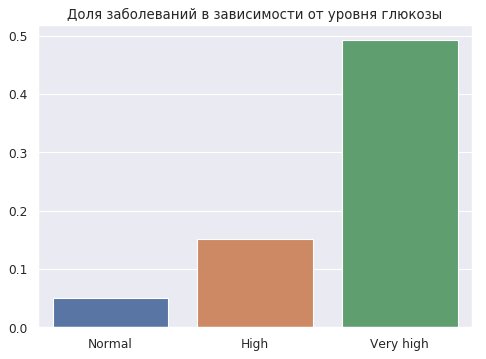

In [23]:
fig = plt.figure(dpi=DPI, figsize=(7, 5))
data = np.array(grouped_by_glucose.Outcome / 
                (df.groupby(by="glucose_group", as_index=False).count().Outcome))

plt.title("Доля заболеваний в зависимости от уровня глюкозы")
sns.barplot(x=np.arange(1, 4), y=data)
xlabels = ["Normal", "High", "Very high"]
plt.ylabel("")
plt.xlabel("")
plt.xticks(np.arange(3), xlabels)
plt.show()
fig.savefig("density_glucose.jpg")

In [24]:
#сделаем таблицу частот
glucose_table = np.zeros((3, 4))

glucose_table[1][:3] = grouped_by_glucose.Outcome # диабет при различном уровне сахара
glucose_table[1][-1] = sum(glucose_table[1][:3])
glucose_table[0][-1] = N - glucose_table[1][-1] # нет диабета
glucose_table[0][:3] = 
    np.array(df.groupby(by='glucose_group', as_index=False).count().Outcome) - glucose_table[1][:3]
glucose_table[2] = glucose_table[0] + glucose_table[1]

glucose_df = pd.DataFrame(glucose_table, dtype=int,
                      columns=["Normal", "High", "Very high", "Total"], 
                      index=["Healthy", "Diabetes", "Total"])
glucose_df

,Normal,High,Very high,Total
Healthy,19,190,146,355
Diabetes,1,34,142,177
Total,20,224,288,532


In [25]:
# условные вероятности
glucose_cond = np.copy(glucose_table)
glucose_cond[0] /= glucose_cond[-1]
glucose_cond[1] /= glucose_cond[-1]
glucose_cond[-1] /= glucose_cond[-1][-1]

glucose_cond_df = pd.DataFrame(glucose_cond, dtype=float,
                      columns=["Normal", "High", "Very high", "Total"], 
                      index=["Healthy", "Diabetes", "Total"])
glucose_cond_df

,Normal,High,Very high,Total
Healthy,0.950000,0.848214,0.506944,0.667293
Diabetes,0.050000,0.151786,0.493056,0.332707
Total,0.037594,0.421053,0.541353,1.000000


In [26]:
# обычные вероятности (количество / N)
glucose_table /= glucose_table[-1][-1]

glucose_df = pd.DataFrame(glucose_table, dtype=float,
                      columns=["Normal", "High", "Very high", "Total"], 
                      index=["Healthy", "Diabetes", "Total"])
glucose_df

,Normal,High,Very high,Total
Healthy,0.035714,0.357143,0.274436,0.667293
Diabetes,0.001880,0.063910,0.266917,0.332707
Total,0.037594,0.421053,0.541353,1.000000


In [27]:
# индексы Кетле и средний вклад признака
glucose_quetlet_table = np.zeros((2, 3))
glucose_quetlet_table[0][:3] = \
    glucose_table[0][:3] / (glucose_table[-1][:3] * glucose_table[0][-1]) - 1
glucose_quetlet_table[1][:3] = \ 
    glucose_table[1][:3] / (glucose_table[-1][:3] * glucose_table[1][-1]) - 1

glucose_quetlet_mean = np.copy(glucose_quetlet_table)

glucose_quetlet_mean[0][:3] *= (glucose_table[0][:3] / glucose_table[-1][-1])
glucose_quetlet_mean[1][:3] *= (glucose_table[1][:3] / glucose_table[-1][-1])
print(np.round(sum(glucose_quetlet_mean[0][:3]) + sum(glucose_quetlet_mean[1][:3]), decimals=6),
      np.round(glucose_quetlet_mean[glucose_quetlet_mean > 0].sum(), decimals=6))

glucose_quetlet_df = pd.DataFrame(glucose_quetlet_table, dtype=float,
                      columns=["Normal", "High", "Very high"], 
                      index=["Healthy", "Diabetes"])
glucose_quetlet_df

0.138306 0.240603


,Normal,High,Very high
Healthy,0.423662,0.271127,-0.240297
Diabetes,-0.849718,-0.543785,0.481952


In [28]:
# теперь посчитаем Xi-квадрат:

glucose_expected = np.zeros((2, 3))
glucose_expected[0] = glucose_table[-1][:3] * glucose_table[0][-1]
glucose_expected[1] = glucose_table[-1][:3] * glucose_table[1][-1]

xi_square = np.zeros((2, 3))
xi_square[0] = (glucose_table[0][:3] - glucose_expected[0]) ** 2 / glucose_expected[0]
xi_square[1] = (glucose_table[1][:3] - glucose_expected[1]) ** 2 / glucose_expected[1]

print(np.round(np.nansum(xi_square), decimals=6))
glucose_xi_square = pd.DataFrame(xi_square, dtype=float,
                      columns=["Normal", "High", "Very high"], 
                      index=["Healthy", "Diabetes"])
glucose_xi_square

0.138306


,Normal,High,Very high
Healthy,0.004503,0.020654,0.020859
Diabetes,0.009031,0.041424,0.041836


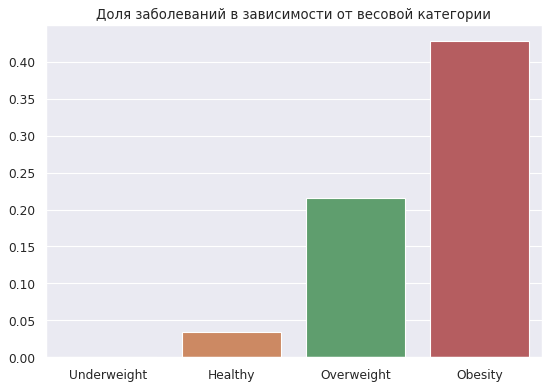

In [29]:
fig = plt.figure(dpi=DPI, figsize=(8, 5.5))
data = np.array(grouped_by_bmi.Outcome / 
                (df.groupby(by="BMI_group", as_index=False).count().Outcome))

plt.title("Доля заболеваний в зависимости от весовой категории")
sns.barplot(x=np.arange(4), y=data)
xlabels = ["Underweight", "Healthy", "Overweight", "Obesity"]
plt.ylabel("")
plt.xlabel("")
plt.xticks(np.arange(4), xlabels)
plt.show()
fig.savefig("density_bmi.jpg")

In [30]:
#сделаем таблицу частот
bmi_table = np.zeros((3, 5))

bmi_table[1][:4] = grouped_by_bmi.Outcome # диабет в различных возрастных категориях
bmi_table[1][-1] = sum(bmi_table[1][:4])
bmi_table[0][-1] = N - bmi_table[1][-1] # нет диабета
bmi_table[0][:4] = \ 
    np.array(df.groupby(by='BMI_group', as_index=False).count().Outcome) - bmi_table[1][:4]
bmi_table[2] = bmi_table[0] + bmi_table[1]

bmi_df = pd.DataFrame(bmi_table, dtype=int,
                      columns=["Underweight", "Healthy", "Overweight", "Obesity", "Total"], 
                      index=["Healthy", "Diabetes", "Total"])
bmi_df

,Underweight,Healthy,Overweight,Obesity,Total
Healthy,2,57,98,198,355
Diabetes,0,2,27,148,177
Total,2,59,125,346,532


In [31]:
# условные вероятности 

bmi_cond = np.copy(bmi_table)
bmi_cond[0] /= bmi_cond[-1]
bmi_cond[1] /= bmi_cond[-1]
bmi_cond[-1] /= bmi_cond[-1][-1]

bmi_cond_df = pd.DataFrame(bmi_cond, dtype=float,
                      columns=["Underweight", "Healthy", "Overweight", "Obesity", "Total"], 
                      index=["Healthy", "Diabetes", "Total"])
bmi_cond_df

,Underweight,Healthy,Overweight,Obesity,Total
Healthy,1.000000,0.966102,0.784000,0.572254,0.667293
Diabetes,0.000000,0.033898,0.216000,0.427746,0.332707
Total,0.003759,0.110902,0.234962,0.650376,1.000000


In [32]:
# таблица вероятностей (количество / N)
bmi_table /= bmi_table[-1][-1]
bmi_df = pd.DataFrame(bmi_table, dtype=float,
                      columns=["Underweight", "Healthy", "Overweight", "Obesity", "Total"], 
                      index=["Healthy", "Diabetes", "Total"])
bmi_df

,Underweight,Healthy,Overweight,Obesity,Total
Healthy,0.003759,0.107143,0.184211,0.372180,0.667293
Diabetes,0.000000,0.003759,0.050752,0.278195,0.332707
Total,0.003759,0.110902,0.234962,0.650376,1.000000


In [33]:
# теперь посчитаем индекс Кетле для веса
bmi_quetlet = np.zeros((2, 4))
bmi_quetlet[0] = bmi_table[0][:4] / (bmi_table[0][-1] * bmi_table[-1][:4]) - 1
bmi_quetlet[1] = bmi_table[1][:4] / (bmi_table[1][-1] * bmi_table[-1][:4]) - 1

# и средний вклад признака
bmi_quetlet_mean = np.copy(bmi_quetlet)
bmi_quetlet_mean[0] *= (bmi_table[0][:4] / bmi_table[-1][-1])
bmi_quetlet_mean[1] *= (bmi_table[1][:4] / bmi_table[-1][-1])
print(np.round(sum(bmi_quetlet_mean[0]) + sum(bmi_quetlet_mean[1]), decimals=6),
      np.round(bmi_quetlet_mean[bmi_quetlet_mean > 0].sum(), decimals=6))

bmi_quetlet_df = pd.DataFrame(bmi_quetlet,
                      columns=["Underweight", "Healthy", "Overweight", "Obesity"], 
                      index=["Healthy", "Diabetes"])

bmi_quetlet_df

0.087351 0.161537


,Underweight,Healthy,Overweight,Obesity
Healthy,0.498592,0.447792,0.174896,-0.142424
Diabetes,-1.000000,-0.898114,-0.350780,0.285654


In [34]:
# а здесь посчитаем xi-квадрат через ожидаемое кол-во наблюдений в предположении нулевой корреляции

bmi_expected = np.zeros((2, 4))
bmi_expected[0] = bmi_table[-1][:4] * bmi_table[0][-1]
bmi_expected[1] = bmi_table[-1][:4] * bmi_table[1][-1]

xi_square = np.zeros((2, 4))
xi_square[0] = (bmi_table[0][:4] - bmi_expected[0]) ** 2 / bmi_expected[0]
xi_square[1] = (bmi_table[1][:4] - bmi_expected[1]) ** 2 / bmi_expected[1]
print(np.round(np.nansum(xi_square), decimals=6))

bmi_xi_square = pd.DataFrame(xi_square,
                      columns=["Underweight", "Healthy", "Overweight", "Obesity"], 
                      index=["Healthy", "Diabetes"])
bmi_xi_square

0.087351


,Underweight,Healthy,Overweight,Obesity
Healthy,0.000624,0.014839,0.004796,0.008803
Diabetes,0.001251,0.029762,0.009619,0.017657


Часть 5: для визуализации с помощью метода главных компонент выберем следующие признаки - уровень глюкозы в крови, давление, толщину кожной складки и ИМТ.

In [35]:
need_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
centered_df = pd.DataFrame()

for feature in need_features: # нормализация размахом
    mean_f, max_f, min_f = df[feature].mean(), df[feature].max(), df[feature].min()
    centered_df[feature] = (df[feature] - mean_f) / (max_f - min_f)

target = df.Outcome.to_numpy()
Y = centered_df.to_numpy()

Собственные значения: [0.05328103 0.02565309 0.01597671 0.00545817]


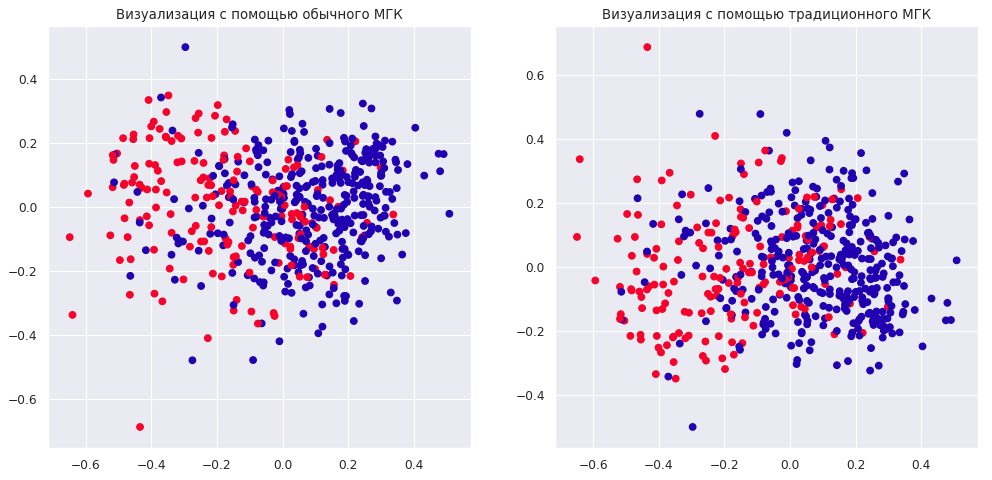

In [37]:
color = ['xkcd:cherry red' if target[i] == 1 else 'xkcd:ultramarine' 
         for i in range(len(centered_df))]

# 1: обыкновенный
from numpy.linalg import svd

U, S, VT = svd(Y, full_matrices=False)
x, y = U.dot(np.diag(S))[:,0], U.dot(np.diag(S))[:,1]

# 2: традиционный
from numpy.linalg import eig

B = np.cov(Y.T) # матрица ковариации
lambda_val, vectors = eig(B)
print("Собственные значения:", lambda_val) # уже в нужном порядке
first_vector = np.array(vectors[:,0], dtype='float')
first_component = Y.dot(first_vector)
second_vector = np.array(vectors[:,1], dtype='float')
second_component = Y.dot(second_vector)

fig = plt.figure(dpi=DPI, figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Визуализация с помощью обычного МГК")
plt.scatter(x, y, c=color)

plt.subplot(1, 2, 2)
plt.title("Визуализация с помощью традиционного МГК")
plt.scatter(first_component, second_component, c=color)

plt.show()
fig.savefig("both_svd.jpg")

Полученные изображения одинаковы с точностью до знака одной из компонент.

Часть 6: линейная регрессия

В качестве двух численных признаков возьмем BMI и SkinThickness, относительно линейно зависящих друг от друга.

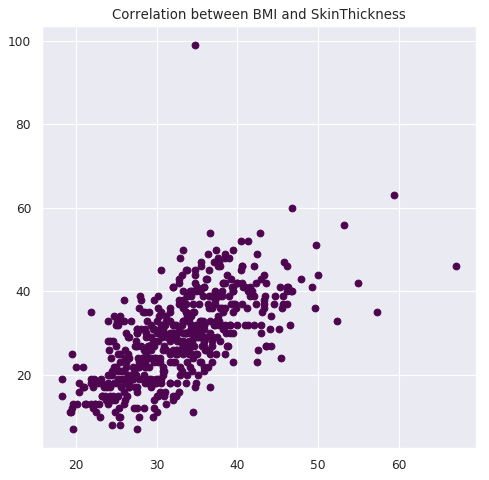

In [38]:
first_feature, second_feature = 'BMI', 'SkinThickness'

fig = plt.figure(dpi=DPI, figsize=(7, 7))
plt.title(f'Correlation between {first_feature} and {second_feature}')
plt.scatter(df[first_feature], df[second_feature], color="xkcd:plum purple")
fig.savefig("scatterplot_features.jpg")
plt.show()

In [39]:
from sklearn.linear_model import LinearRegression

train = df[(df[second_feature] < 60) & (df[second_feature] > 10) 
           & (df[first_feature] < 50) & (df[first_feature] > 20)]

need_features_index = np.where(df.columns == first_feature)
linear_model = LinearRegression().fit(train.iloc[:,need_features_index[0]], train[second_feature])

k = 0.9952386813919191 , b = -3.402710787275762


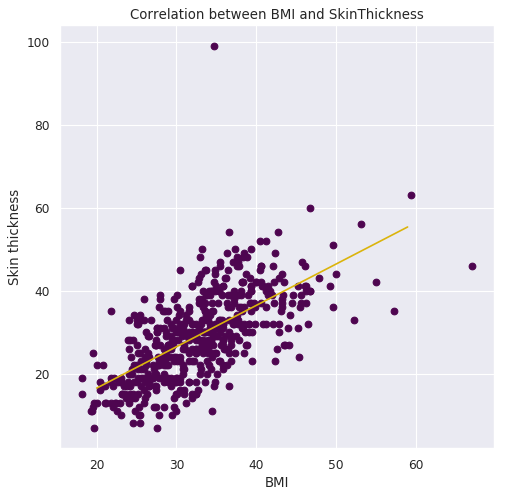

In [40]:
print("k =", linear_model.coef_[0], ", b =", linear_model.intercept_)

x = np.arange(20, 60)
fig = plt.figure(dpi=DPI, figsize=(7, 7))
plt.title(f'Correlation between {first_feature} and {second_feature}')
plt.xlabel('BMI')
plt.ylabel('Skin thickness')
plt.plot(x, x * linear_model.coef_[0] + linear_model.intercept_, color='xkcd:gold')
plt.scatter(df[first_feature], df[second_feature], color="xkcd:plum purple")
fig.savefig("linear_regression.jpg")
plt.show()

In [41]:
from sklearn.metrics import r2_score
cov = np.corrcoef(train[second_feature], 
                  linear_model.predict(train.iloc[:,need_features_index[0]]))
print("R^2 = %.6f" % r2_score(train[second_feature], 
                              linear_model.predict(train.iloc[:,need_features_index[0]])))
print("r = %.6f" % cov[0][1])

R^2 = 0.413626
r = 0.643138
